In [5]:
import sys
!{sys.executable} -m pip install --upgrade boto3 --user


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [279]:
import pandas as pd
import boto3
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error

In [10]:
#df=pd.read_excel('Traffic.xlsx')

df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df['DL_user_tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3401-2']
df_filter['PktDelay']=df_filter['L.Traffic.DL.PktDelay.Time.QCI.9 (ms)']/1000000000

df_filter=df_filter[['DL_user_tput','PktDelay']]

#df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter

C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,DL_user_tput,PktDelay
Start Time,,
2013-08-28 00:00:00,0.684966,0.915593
2013-08-28 00:15:00,0.566828,1.134761
2013-08-28 00:30:00,0.613085,1.100809
2013-08-28 00:45:00,0.578675,1.029742
2013-08-28 01:00:00,0.481141,1.139496
...,...,...
2013-09-04 22:45:00,1.007606,0.556276
2013-09-04 23:00:00,1.110101,0.518872
2013-09-04 23:15:00,1.000562,0.568380


In [11]:
df_filter.to_csv("df_filter.csv")

In [12]:
df_filter['item_id']='cell'

In [13]:
FORECAST_LENGTH=96

train=df_filter.iloc[:-FORECAST_LENGTH]

In [153]:
train_target_series=train[["DL_user_tput","item_id"]]
train_related_series=train[["PktDelay","item_id"]]

In [179]:
train_target_series.to_csv("tput_target_series1.csv",header=None)
train_related_series.to_csv("tput_related_series.csv",header=None)

In [180]:
bucket_name="capacitymonitoring"
region="us-east-1"




In [181]:
role_arn="arn:aws:iam::813207135964:role/Forecast_manual"

In [182]:
s3=boto3.client("s3",region_name=region)

C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\boto3\compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [183]:
DATASET_FREQUENCY="15min"
TIMESTAMP_FORMAT="YYYY-mm-DD hh:mm:ss"
dataset_group="quarterly_forecast_dataset_group"



In [184]:
forecast_client=boto3.client(service_name='forecast',region_name=region)
forecastquery_client=boto3.client(service_name='forecastquery',region_name=region)

C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\boto3\compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [185]:
create_dataset_group_response=forecast_client.create_dataset_group(
Domain="CUSTOM",
DatasetGroupName=dataset_group)

ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreateDatasetGroup operation: A dataset group already exists with the arn: arn:aws:forecast:us-east-1:813207135964:dataset-group/quarterly_forecast_dataset_group

In [186]:
dataset_group_arn=create_dataset_group_response['DatasetGroupArn']
describe=forecast_client.describe_dataset_group(DatasetGroupArn=dataset_group_arn)
print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

ACTIVE
2022-08-27 22:54:27.895000+03:00
2022-08-28 11:10:47.389000+03:00


In [187]:
target_schema={
    "Attributes": [
        {
            "AttributeName":"timestamp",
            "AttributeType":"timestamp"            
        },
        {
            "AttributeName":"target_value",
            "AttributeType":"float"                        
        },
        {
            "AttributeName":"item_id",
            "AttributeType":"string"                        
        }        
    ]    
}

In [282]:
target_dataset_name="dl_tput2"

In [283]:
r=forecast_client.create_dataset(
    Domain="CUSTOM",
    DatasetType='TARGET_TIME_SERIES',
    DatasetName=target_dataset_name,
    DataFrequency=DATASET_FREQUENCY,
    Schema=target_schema
)

In [284]:
target_dataset_arn=r['DatasetArn']
describe=forecast_client.describe_dataset(DatasetArn=target_dataset_arn)
print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

ACTIVE
2022-08-28 13:47:27.477000+03:00
2022-08-28 13:47:27.477000+03:00


In [285]:
related_schema={
    "Attributes": [
        {
            "AttributeName":"timestamp",
            "AttributeType":"timestamp"            
        },
        {
            "AttributeName":"PktDelay_value",
            "AttributeType":"float"                        
        },
        {
            "AttributeName":"item_id",
            "AttributeType":"string"                        
        }        
    ]    
}

In [286]:
dataset_arns=[target_dataset_arn]
forecast_client.update_dataset_group(
    DatasetGroupArn=dataset_group_arn,
    DatasetArns=dataset_arns
)

{'ResponseMetadata': {'RequestId': '84cb1c08-c4a1-41e8-bf88-d802aa2829c2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 28 Aug 2022 10:47:40 GMT',
   'x-amzn-requestid': '84cb1c08-c4a1-41e8-bf88-d802aa2829c2',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [287]:
s3r=boto3.resource('s3',region_name=region)
s3r.Bucket(bucket_name).Object(
    "tput_target_series1.csv").upload_file("tput_target_series1.csv")


C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\boto3\compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [288]:
s3_target_path=f"s3://{bucket_name}/tput_target_series1.csv"

In [289]:
target_import_job_response=forecast_client.create_dataset_import_job(
    DatasetImportJobName=dataset_group,
    DatasetArn=target_dataset_arn,
    DataSource={
        "S3Config":{
            "Path":s3_target_path,
            "RoleArn":role_arn            
        }        
    },
    TimestampFormat=TIMESTAMP_FORMAT
    

)

In [296]:
target_import_job_arn=target_import_job_response['DatasetImportJobArn']

describe=forecast_client.describe_dataset_import_job(DatasetImportJobArn=target_import_job_arn)
print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

ACTIVE
2022-08-28 13:48:02.188000+03:00
2022-08-28 13:50:05.265000+03:00


In [297]:
algorithm_arn='arn:aws:forecast:::algorithm/Deep_AR_Plus'
predictor_name='deep_ar_plus_predictor2'

In [298]:
create_predictor_response=forecast_client.create_predictor(
    PredictorName=predictor_name,
    AlgorithmArn=algorithm_arn,
    ForecastHorizon=FORECAST_LENGTH,
    PerformAutoML=False,
    PerformHPO=True,
    InputDataConfig={"DatasetGroupArn":dataset_group_arn},
    FeaturizationConfig={"ForecastFrequency":DATASET_FREQUENCY},

)

In [299]:
predictor_arn=create_predictor_response['PredictorArn']

In [302]:
describe=forecast_client.describe_predictor(PredictorArn=predictor_arn)

print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

CREATE_IN_PROGRESS
2022-08-28 13:51:12.237000+03:00
2022-08-28 13:55:15.050000+03:00


In [256]:
forecast_client.get_accuracy_metrics(PredictorArn=predictor_arn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 0.3459784079407749,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.2012423609598573},
       {'Quantile': 0.5, 'LossValue': 0.18487019857220538},
       {'Quantile': 0.1, 'LossValue': 0.1166505186843096}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.18540690549296554,
        'RMSE': 0.3459784079407749,
        'MASE': 0.8720776836401212,
        'MAPE': 0.20280772036104652}],
      'AverageWeightedQuantileLoss': 0.1675876927387908}},
    {'TestWindowStart': datetime.datetime(2013, 9, 3, 3, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2013, 9, 4, 3, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 0.3459784079407749,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.2012423609598

In [257]:
forecast_name="deep_ar_plus_forecast1"

In [258]:
create_forecast_response=forecast_client.create_forecast(
    ForecastName=forecast_name,
    PredictorArn=predictor_arn
)

In [259]:
forecast_arn=create_forecast_response['ForecastArn']

In [270]:
describe=forecast_client.describe_forecast(ForecastArn=forecast_arn)

print(describe['Status'])
print(describe['CreationTime'])
print(describe['LastModificationTime'])

ACTIVE
2022-08-28 13:29:03.813000+03:00
2022-08-28 13:40:54.890000+03:00


In [271]:
forecast_response=forecastquery_client.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id":'cell'}

)

In [ ]:
forecast_response

In [273]:
def parse_aws_forecast(d10,d50,d90):
    ts=pd.Timestamp(d10['Timestamp'])
    val1=d10['Value']
    val2=d50['Value']
    val3=d90['Value']
    return ts,val1,val2,val3

In [274]:
p10=forecast_response['Forecast']['Predictions']['p10']
p50=forecast_response['Forecast']['Predictions']['p50']
p90=forecast_response['Forecast']['Predictions']['p90']

parsed=[parse_aws_forecast(d1,d2,d3) for d1,d2,d3 in zip(p10,p50,p90)]
forecast_df=pd.DataFrame(parsed,columns=['timestamp','p10','p50','p90'])
forecast_df.set_index('timestamp',inplace=True)

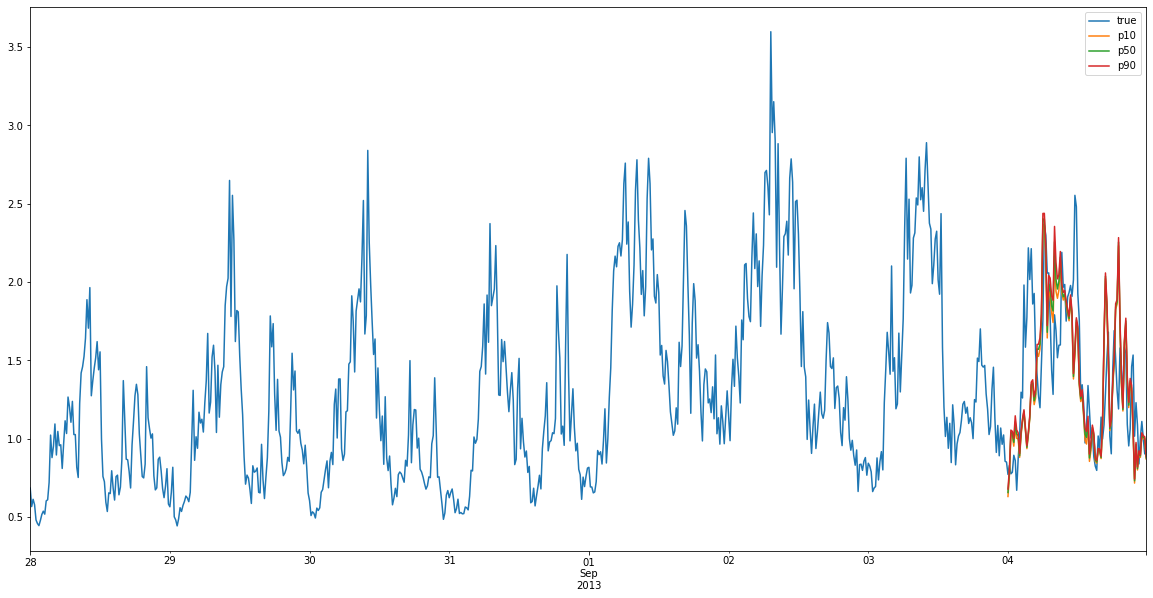

In [275]:
true_df=df_filter[['DL_user_tput']].copy()
true_df.columns=['true']

full_df=true_df.join(forecast_df,how='outer')
full_df[['true','p10','p50','p90']].plot(figsize=(20,10))

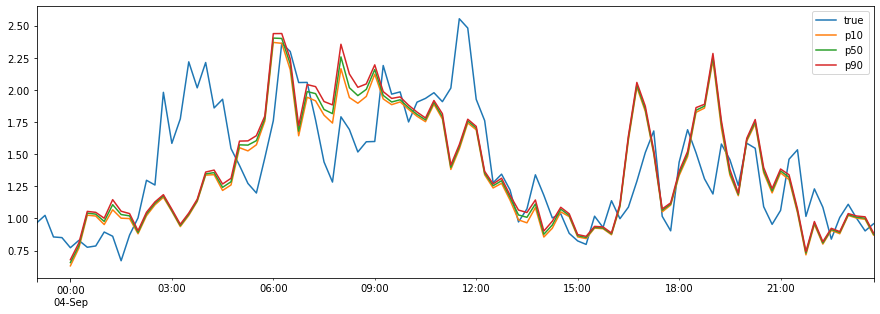

In [276]:

full_df[-100:].plot(figsize=(15,5))

In [281]:
test_tput=full_df.iloc[-96:]['true']

RMSE0=np.sqrt(mean_squared_error(test_tput,full_df.iloc[-96:]['p10']))

print("p10 RMSE:",RMSE0)

RMSE1=np.sqrt(mean_squared_error(test_tput,full_df.iloc[-96:]['p50']))

print("p50 RMSE:",RMSE1)

RMSE2=np.sqrt(mean_squared_error(test_tput,full_df.iloc[-96:]['p90']))

print("p90 RMSE:",RMSE2)




#full_df['true'][-100:]

p10 RMSE: 0.3812031642417829
p50 RMSE: 0.3849369334968468
p90 RMSE: 0.39086060512651616
